In [1]:
import random as rnd
rnd.seed(123)
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(1234)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
import matplotlib.pyplot as plt

#Allocation of memory for the GPU process
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
logical = tf.config.experimental.list_logical_devices('GPU')
print(logical[0])

Using TensorFlow backend.


LogicalDevice(name='/device:GPU:0', device_type='GPU')


In [2]:
# Embedding
max_features = 20000
maxlen = 120
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 128

# Training
batch_size = 64
epochs = 8 #modify as required, should be even


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


#Data Split
val_split_start = 20000
x_val = x_train[val_split_start:]
y_val = y_train[val_split_start:]
x_train = x_train[0:val_split_start]
y_train = y_train[0:val_split_start]

print(len(x_train), 'train sequences')
print(len(x_val), 'validation sequences')
print(len(x_test), 'test sequences')


print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


Loading data...
20000 train sequences
5000 validation sequences
25000 test sequences
Pad sequences (samples x time)


In [3]:
print('Build models...')

class Network(Sequential):
  def __init__(self):
    super().__init__()
    self.add(Embedding(max_features, embedding_size, input_length=maxlen))
    self.add(Dropout(0.25))
    self.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
    self.add(MaxPooling1D(pool_size=pool_size))
    self.add(LSTM(lstm_output_size))
    self.add(Dense(1))
    self.add(Activation('sigmoid'))

#Default for starting weights
model = Network()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
model_benchmark = Network()
model_small_set = Network()
model_iterative_training = Network()


#Benchmark
model_benchmark.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_benchmark.set_weights(model.get_weights())


print('Train Benchmark')
history_bench = model_benchmark.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),verbose=2)
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Benchmark test score:', score)
print('Benchmark test accuracy:', acc)
model_benchmark.save('Mdl_Bench1.h5')

#Smaller data sets for semi-supervised training
small_set_limit = 2000
x_train1 = x_train[0:small_set_limit]
y_train1 = y_train[0:small_set_limit]
x_train2 = x_train[small_set_limit:20000]

#Smaller training set
print('Train on smaller set')
model_small_set.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_small_set.set_weights(model.get_weights())


history_small = model_small_set.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val), verbose=2)
score, acc = model_small_set.evaluate(x_test, y_test, batch_size=batch_size)
print('Small model test score:', score)
print('Small model test accuracy:', acc)
model_small_set.save('Mdl_Small1.h5')


#Iterative_train
print('Train iter model')
model_iterative_training.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_iterative_training.set_weights(model.get_weights())

history_iter1 = model_iterative_training.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=int(epochs/2-1),
          validation_data=(x_val, y_val), verbose=2)

a = model_iterative_training.predict(x_train2)

i = 0
k = np.array([1])
j = np.array([0])
for x in np.nditer(a):
     if x>=0.8:
        x_train1 = np.append(x_train1, np.array([x_train2[i]]), axis=0)
        y_train1 = np.append(y_train1, k)
        i += 1
     elif x<=0.2:
        x_train1 = np.append(x_train1, np.array([x_train2[i]]), axis=0)
        y_train1 = np.append(y_train1, j)
        i += 1
     else:
        i += 1


history_iter2 = model_iterative_training.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=int(epochs/2+1),
          validation_data=(x_val, y_val), verbose=2)

score, acc = model_iterative_training.evaluate(x_test, y_test, batch_size=batch_size, verbose=2)
print('Iterative test score:', score)
print('Iterative test accuracy:', acc)
model_iterative_training.save('Mdl_iter1.h5')

Build models...
Model: "network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)   

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
 - 14s - loss: 0.4160 - accuracy: 0.7922 - val_loss: 0.3085 - val_accuracy: 0.8718
Epoch 2/8
 - 12s - loss: 0.1959 - accuracy: 0.9280 - val_loss: 0.3149 - val_accuracy: 0.8608
Epoch 3/8
 - 12s - loss: 0.1010 - accuracy: 0.9657 - val_loss: 0.4109 - val_accuracy: 0.8598
Epoch 4/8
 - 12s - loss: 0.0457 - accuracy: 0.9861 - val_loss: 0.4534 - val_accuracy: 0.8530
Epoch 5/8
 - 12s - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.7505 - val_accuracy: 0.8534
Epoch 6/8
 - 12s - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.6608 - val_accuracy: 0.8490
Epoch 7/8
 - 12s - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.7272 - val_accuracy: 0.8498
Epoch 8/8
 - 12s - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.7090 - val_accuracy: 0.8480
25000/25000 [==============================] - 3s 107us/step
Benchmark test score: 0.6932648209953308
Benchmark test accuracy: 0.5
Train on smaller set
Train on 2000 samples, validate on 5000 samples
Epoch 1

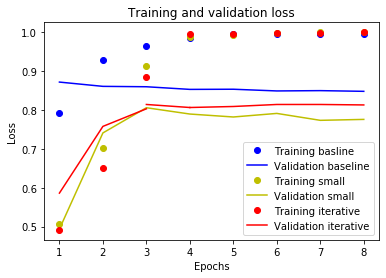

In [4]:
bench_dict = history_bench.history
small_dict = history_small.history
iter1_dict = history_iter1.history
iter2_dict = history_iter2.history
epochs_ar = range(1, epochs+1)
plt.plot(epochs_ar, bench_dict['accuracy'], 'bo', label='Training basline')
plt.plot(epochs_ar, bench_dict['val_accuracy'], 'b', label='Validation baseline')
plt.plot(epochs_ar, small_dict['accuracy'], 'yo', label='Training small')
plt.plot(epochs_ar, small_dict['val_accuracy'], 'y', label='Validation small')
plt.plot(range(1, 4), iter1_dict['accuracy'], 'ro', label='Training iterative')
plt.plot(range(1, 4), iter1_dict['val_accuracy'], 'r', label='Validation iterative')
plt.plot(range(4, 9), iter2_dict['accuracy'], 'ro')
plt.plot(range(4, 9), iter2_dict['val_accuracy'], 'r')
_ = [iter2_dict['val_accuracy'][3], iter2_dict['val_accuracy'][0]]
plt.plot(range(3, 5), _, 'r')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()